In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

Here, we load the serialized DataFrame saved in step 1.

In [2]:
raw_input = pd.read_pickle('input.pkl')

In [3]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit
0,1,90,6,"After some time, the affection between them is...",41,Writing a movie plot,1
1,2,90,6,An e-ticket is a provement that you bought the...,42,Filling in an arrival card,2
2,3,86,6,From:xxx@1234.com To:Herman xxx@1234.com Date:...,43,Creating an office dress code,3
3,4,87,1,"Hi Anna ,How are you . My name's Jayla . My te...",1,Introducing yourself by email,1
4,5,95,1,"Dear Ms Thomas, There are thirty pens and fift...",2,Taking inventory in the office,2


In [4]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180309 entries, 0 to 1180308
Data columns (total 7 columns):
article_id    1180309 non-null int64
grade         1180309 non-null int64
level         1180309 non-null int64
text          1180309 non-null object
topic_id      1180309 non-null int64
topic_text    1180309 non-null object
unit          1180309 non-null int64
dtypes: int64(5), object(2)
memory usage: 63.0+ MB


# Convert Text to Vector Space Representation

Now we convert each document as a vector of tf-idf features. Then we apply Non-negative Matrix Factorization (NMF) to transform the high-dimensional sparse feature space to lower dimensional dense feature space. Finally, we normalize the low dimension vectors by their L2-norm, so Euclidean distances between the feature vectors are proportional to their cosine similarities.

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Choose the number of NMF Components

First we define a helper function:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline


def vsm_representation(n_components, texts, return_error=False):
    """Return the Vector Space represents of a vector of texts, `texts`.
    
    If `return_error` is True, return the reconstruction_error of the NMF.
    Otherwise return the L2 normalized transformed features.            
    """
    tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1, 1), 
                            max_df=0.4, min_df=25, stop_words=en_stopwords)
    
    nmf = NMF(n_components=n_components, init=None, solver='cd', random_state=1234, shuffle=True)
    steps = [('tfidf', tfidf), ('nmf', nmf)]
    
    if not return_error:
        steps.append(('norm', Normalizer(norm='l2')))
                     
    pipeline = Pipeline(steps)
    
    if return_error:    
        pipeline = pipeline.fit(texts)
        return pipeline.named_steps['nmf'].reconstruction_err_
    else:
        return pipeline.fit_transform(texts)              

In [10]:
%%time

vsm_mat = vsm_representation(20, raw_input.text)
vsm_mat.shape

(1180309, 20)

# K-Means Cluster and Optimal Cluster Size

Next we build another helper function to fit a KMeans cluster on the vector space rerpesentation of our text documents.

In [17]:
from sklearn.cluster import MiniBatchKMeans

def cluster_vsm(n_clusters, vsm, batch_size=5000, return_labels=True): 
    """
    Cluster the document VSM using ``MiniBatchKMeans``. 
    
    If `return_labels` is True, return the cluster membership of each row. 
    Otherwise return the `inertia_` attribute, which is a measure of 
    sum of squared errors of each sample relative to the cluster mean.
    """

    clusterer = MiniBatchKMeans(
        n_clusters=n_clusters, 
        compute_labels=True, 
        random_state=1234,
        batch_size=batch_size, 
        tol=1E-3)
    
    clusterer = clusterer.fit(vsm)
    
    if return_labels:
        return clusterer.labels_.copy()
    else:
        return clusterer.inertia_  


# Compare Cluster Assignments with Ground Truth Labels

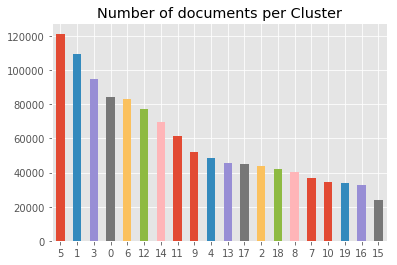

In [18]:
# Extract the cluster assignments assuming 20 clusters
cluster_labels = cluster_vsm(20, vsm_mat)

# Convert to a Series
cluster_labels = pd.Series(index=raw_input.index, data=cluster_labels, name='cluster_labels')

# Plot Count of Labels
label_counts = cluster_labels.value_counts()
label_counts.to_csv('label_counts_large.csv')

ax =label_counts.plot(kind='bar', rot='0', title='Number of documents per Cluster')

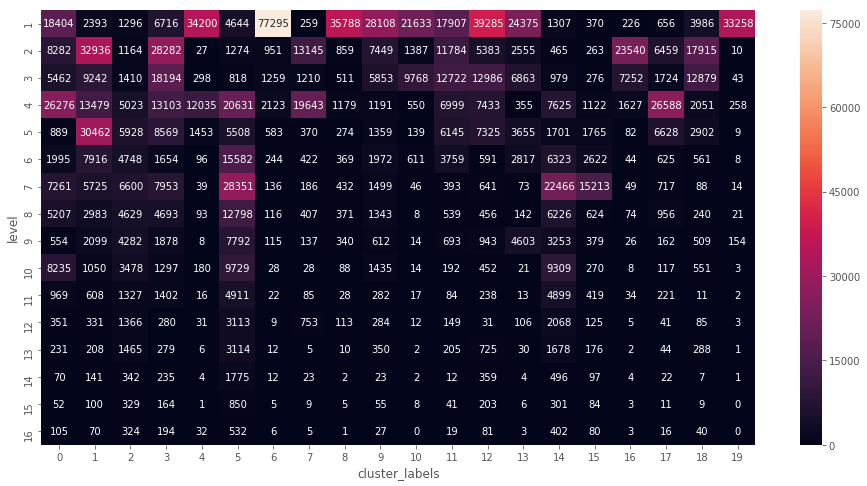

In [19]:
# Cross-tabulate the assigned levels with cluster assignments
ct = pd.crosstab(cluster_labels, raw_input.level).T
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax = sns.heatmap(ct, annot=True, fmt='d', ax=ax)

ct.to_csv('cluster_assignment_vs_labels_large.csv')

Next we calculate the Adjusted Rand Score between the cluster assignments and the ground truth labels, which is a measure of how similar these two label assignments are. 

In [20]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(cluster_labels, raw_input.level)

0.08889796084598833

The adjusted rand score is close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 if they are identical. So this clustering doesn't seem to correspond to the ground truth labels.